# Sequential Decision Making Under Uncertainty: Supplemental Notebook

Author: Kris Reyes (kreyes3@buffalo.edu)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16


Text(0, 0.5, 'y')

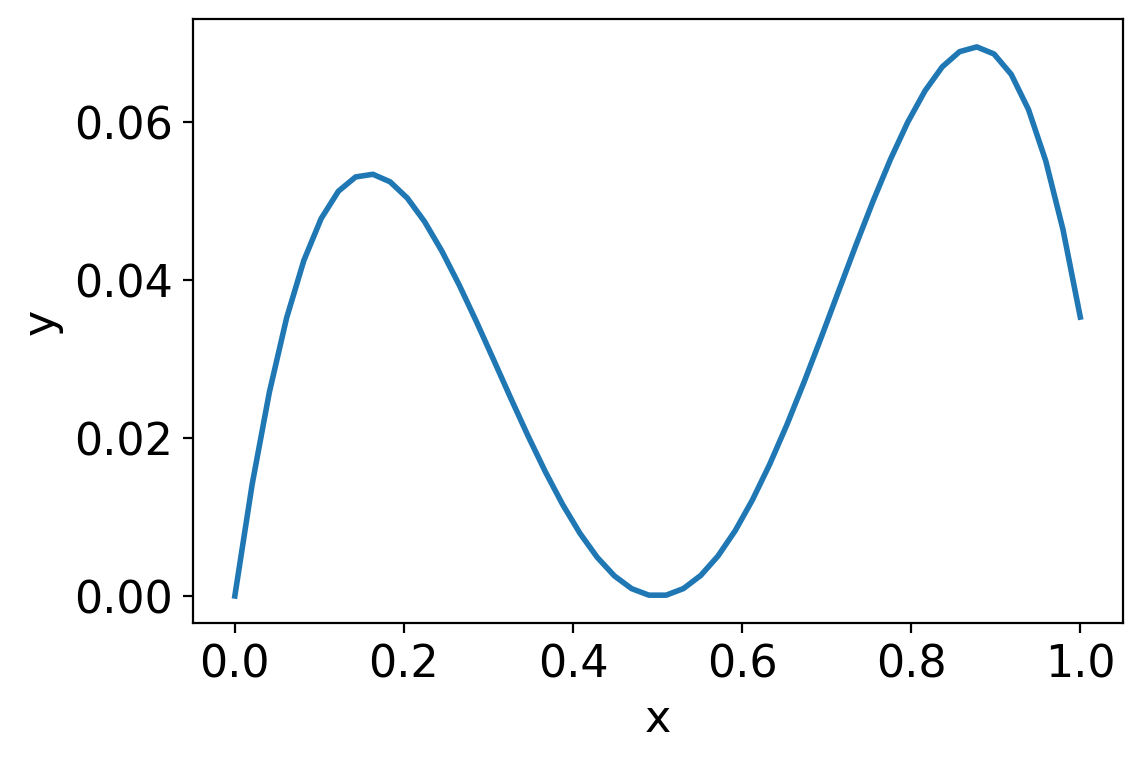

In [122]:
# Here we define a ground truth function -- it is parameterized 
# by two values kappa[0] and kappa[1]
def f(x, kappa):
    return np.sin(6*kappa[0]*x)*(x-kappa[1])**2

kappa_star = [0.5, 0.5]

# plot the ground truth
x_plot = np.linspace(0, 1)
y_plot = f(x_plot, kappa_star)
plt.plot(x_plot, y_plot)
plt.xlabel('x')
plt.ylabel('y')

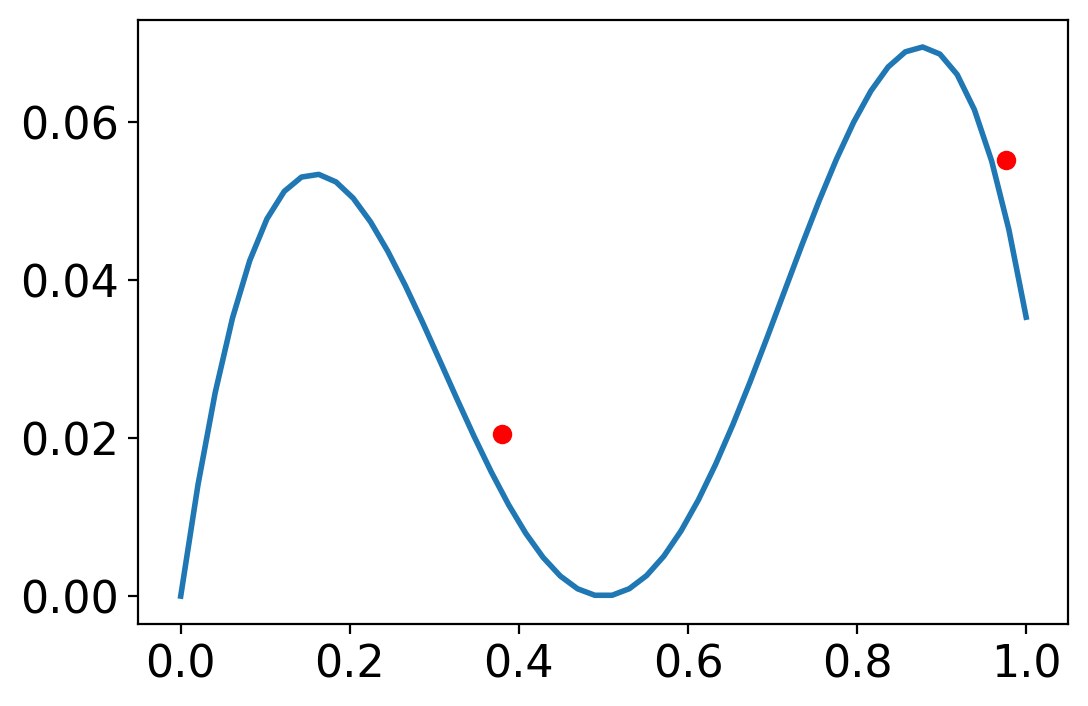

In [123]:
SEED = 1234
rng = np.random.default_rng(seed = SEED)

# Noise standard deviation
SIGMA_W = 1e-2

# Generating a few data points for illustration
x_data = rng.uniform(size=2)
y_data = f(x_data, kappa_star) + rng.normal(scale=SIGMA_W)

# plot truth and observations
plt.plot(x_plot, y_plot)
plt.scatter(x_data, y_data, color='r')

# Belief Models

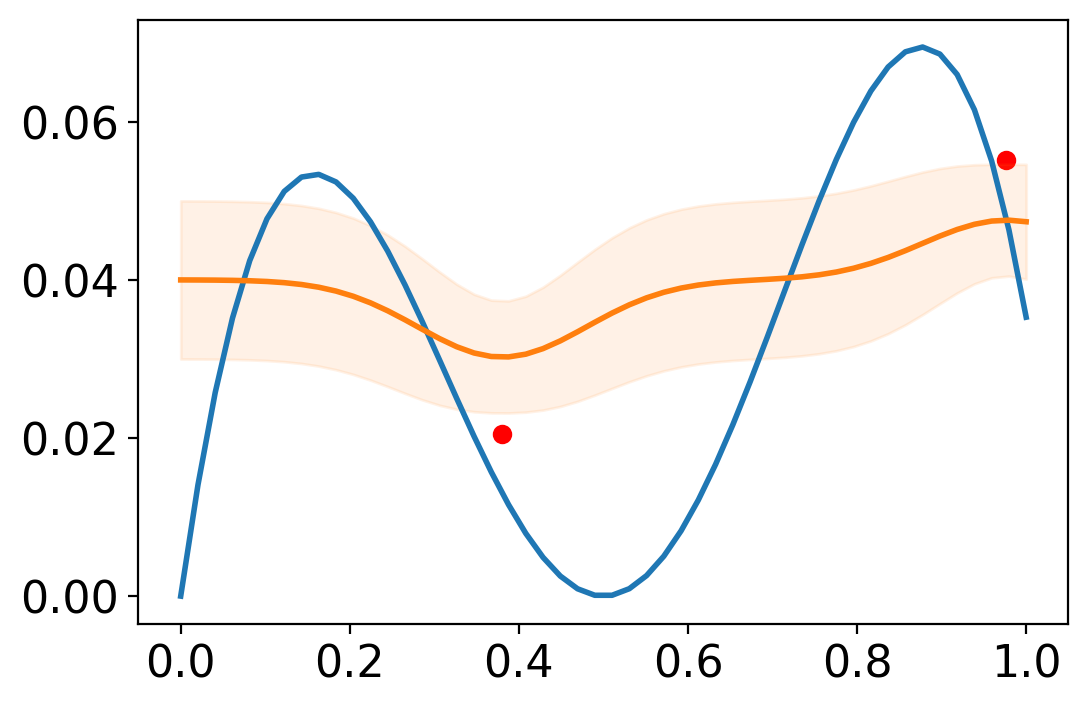

In [124]:
# Gaussian Process Beliefs
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# Prior hyperparameters
LAMBDA_X = 0.1
SIGMA_0 = 1

# Normalizing hyperparameters
MU_Y = 0.04
SIGMA_Y = 1e-2

kernel = SIGMA_0**2*RBF(length_scale = LAMBDA_X)
model = GaussianProcessRegressor(kernel, alpha=(SIGMA_W/SIGMA_Y)**2,
                                 optimizer=None)

# Build posterior distribution

# sklearn's GP library needs its training data two be two dimensional.
# We artificially add an extra dimension using np.newaxis.
model.fit(x_data[:, np.newaxis], (y_data-MU_Y)/SIGMA_Y)

# Plot posterior distribution
y_gp, sig_gp = model.predict(x_plot[:, np.newaxis], return_std=True)

# unnormalize
y_gp = (y_gp * SIGMA_Y) + MU_Y
sig_gp = sig_gp * SIGMA_Y

plt.plot(x_plot, y_plot)
plt.scatter(x_data, y_data, color='r')

h = plt.plot(x_plot, y_gp)
plt.fill_between(x_plot, y_gp + sig_gp, y_gp - sig_gp,
                 color=h[0].get_color(), alpha = 0.1)

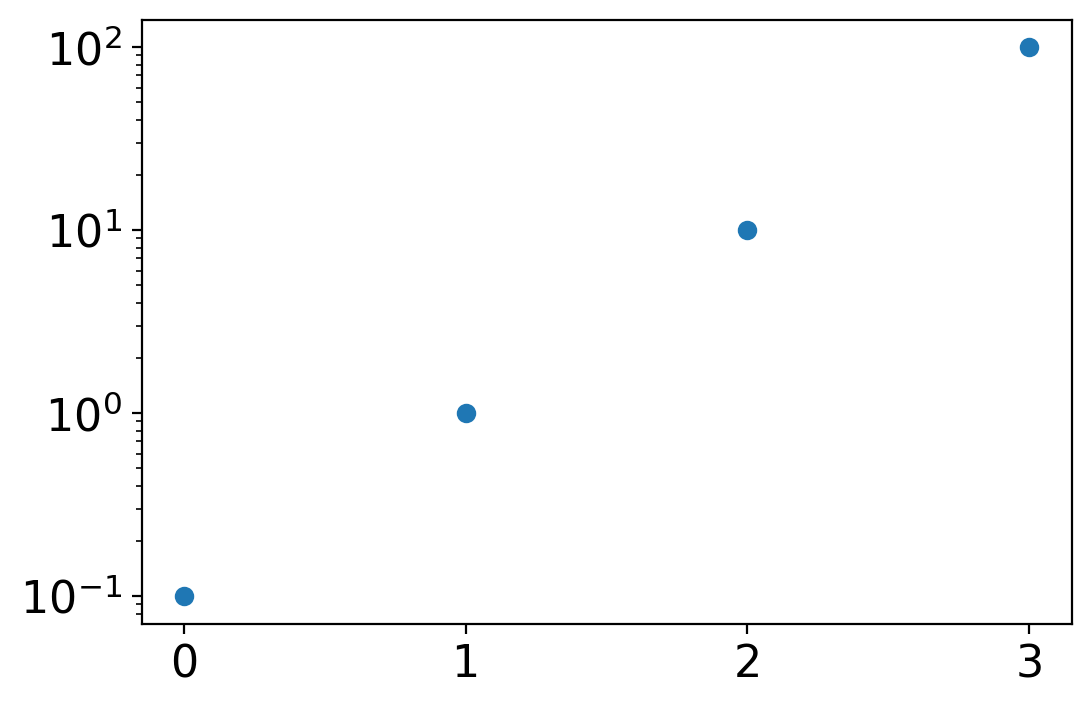

In [125]:
# Hyperparameters to linear parametric model -- using monomial basis
# y = theta_0 + theta_1 x + theta_2 x^2 _ ...

DEGREE = 3
THETA_BOUNDS = np.array([0.1*10**i for i in range(DEGREE+1)])
plt.scatter(range(DEGREE+1), THETA_BOUNDS)
plt.yscale('log')

In [126]:
# prior linear model
mu_theta = np.zeros(DEGREE+1)

# Treat bounds as 2 standard deviations
var_theta = (THETA_BOUNDS/2)**2
Sigma_theta = np.diag(var_theta)

There are closed-form equations to do the Bayesian update of our beliefs on
$\theta$ given observational data $x = (x_1, ..., x_n)^T,$ and
$y = (y_1, ..., y_n)^T.$

\begin{align}
\Phi & = (\varphi(x_1), ..., \varphi(x_n))^T \\
\theta^{n+1} &= \theta^n + \frac{y - \Phi \theta^n}{\sigma^2_W +
\Phi \Sigma^n_\theta \Phi^T} \Sigma^n_\theta \Phi^T \\ \Sigma^{n+1} &=
\Sigma^n_\theta - \frac{\Sigma^n_\theta \Phi^T \Phi \Sigma^n_\theta}{
\sigma^2_W + \Phi \Sigma^n_\theta \Phi^T},
\end{align}

In [127]:
# Posterior update

# Design matrix
Phi = np.array([[x**i for i in range(DEGREE+1)] for x in x_data])

# Posterior beliefs on theta
Gamma = np.eye(2,2)*SIGMA_W**2 + Phi @ Sigma_theta @ Phi.T
posterior_mu_theta = mu_theta + \
                     Sigma_theta @ Phi.T @ np.linalg.solve(Gamma, (y_data - Phi @ mu_theta))
posterior_Sigma_theta = Sigma_theta - \
                        Sigma_theta @ Phi.T @ np.linalg.solve(Gamma, Phi @ Sigma_theta)

$$f^\star \sim \mathcal N (\Phi \theta^n, \Phi \Sigma^N_\theta \Phi^T).$$

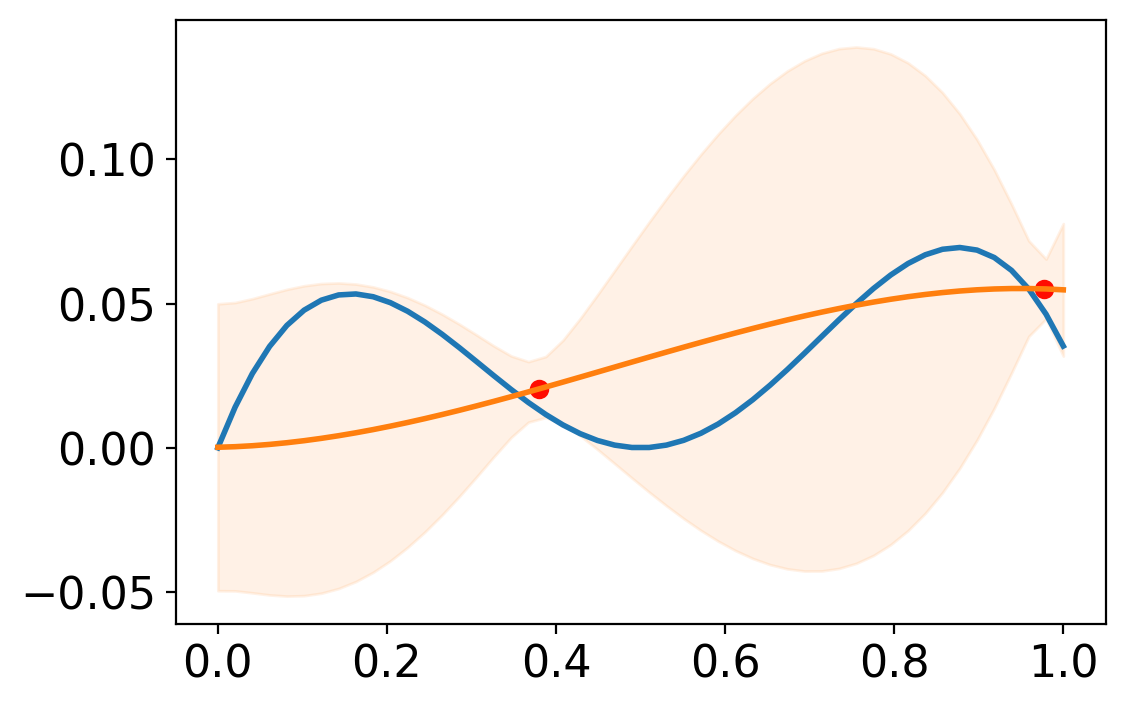

In [128]:
# Posterior predictive distribution for inputs in x_plot
Phi = np.array([[x**i for i in range(DEGREE+1)] for x in x_plot])

y_linear = Phi @ posterior_mu_theta
sig_linear = np.sqrt(np.diag(Phi @ posterior_Sigma_theta @ Phi.T))

plt.plot(x_plot, y_plot)
plt.scatter(x_data, y_data, color='r')

h = plt.plot(x_plot, y_linear)
plt.fill_between(x_plot, y_linear + sig_linear, y_linear - sig_linear,
                 color=h[0].get_color(), alpha = 0.1)


Text(0, 0.5, '$\\kappa_2$')

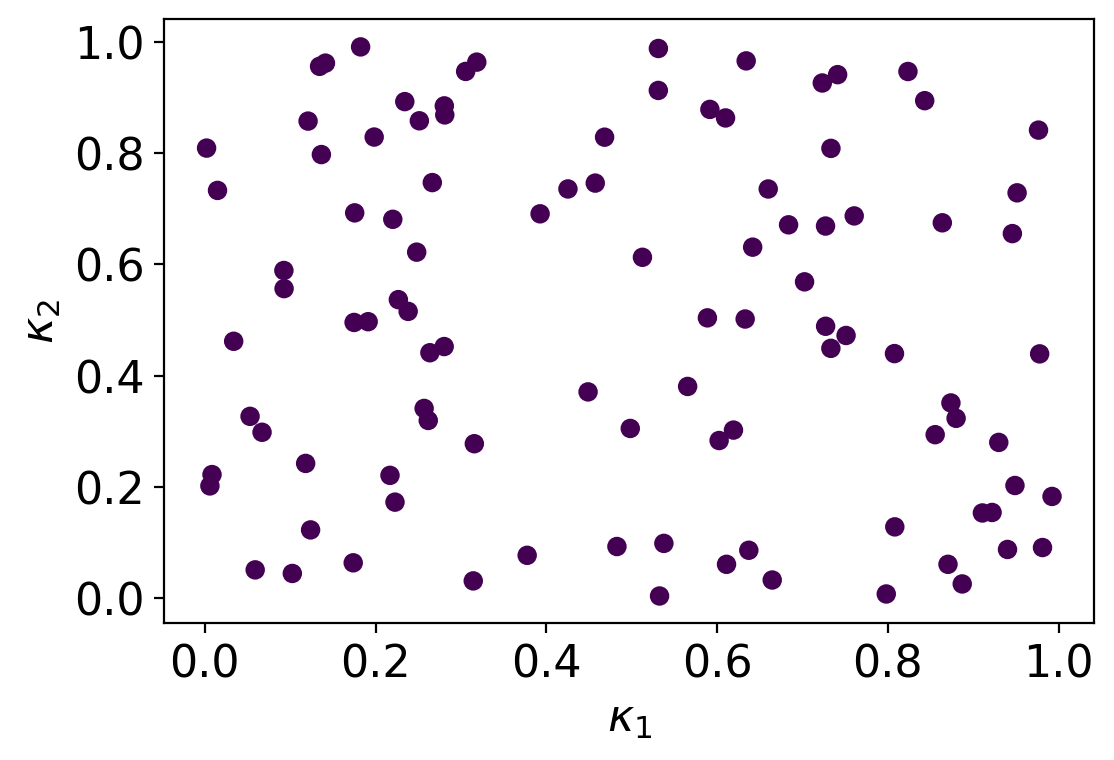

In [129]:
## Beliefs on parameters

# Prior
KAPPA_BOUNDS = np.array([[0,1], [0,1]]).T
NUM_SAMPLES = 100

kappa_samples = rng.uniform(low = KAPPA_BOUNDS[0], high = KAPPA_BOUNDS[1],
                            size=(NUM_SAMPLES, 2))
weights = np.ones(NUM_SAMPLES)/NUM_SAMPLES

plt.scatter(kappa_samples[:, 0], kappa_samples[:, 1], c=weights)
plt.xlabel(r'$\kappa_1$')
plt.ylabel(r'$\kappa_2$')

In [130]:
# Posterior weights
prior_y_pred = np.array([[f(x, k) for x in x_data] for k in kappa_samples])
print(prior_y_pred.shape)

(100, 2)


Text(0, 0.5, '$\\kappa_2$')

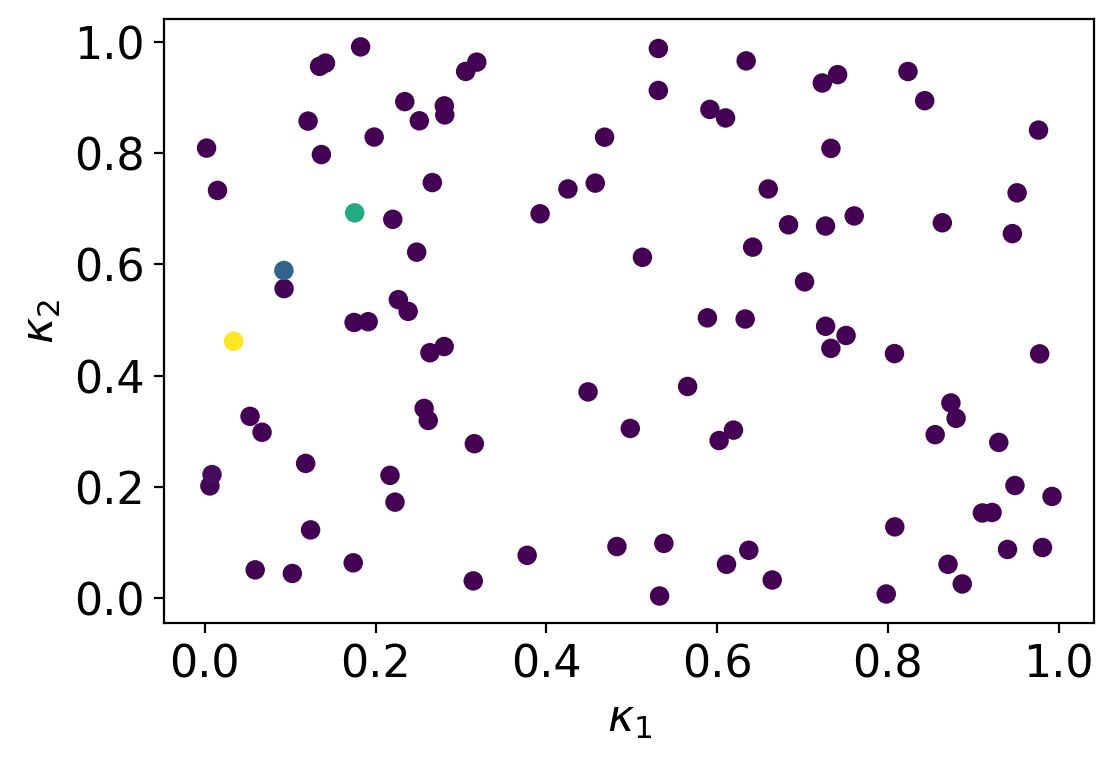

In [131]:
# Bayes' law: likelihood * prior.

# Calculate likelihood for each of the kappas (under Gaussian noise assumption)

log_likelihood = -0.5*np.sum((prior_y_pred-y_data)**2 / SIGMA_W**2, axis=1)

# Bayes's law
posterior_weights = np.multiply(np.exp(log_likelihood), weights)
# Normalize
posterior_weights = posterior_weights / np.sum(posterior_weights)

# plot posterior weights

plt.scatter(kappa_samples[:, 0], kappa_samples[:, 1], c=posterior_weights)
plt.xlabel(r'$\kappa_1$')
plt.ylabel(r'$\kappa_2$')

(100, 50)


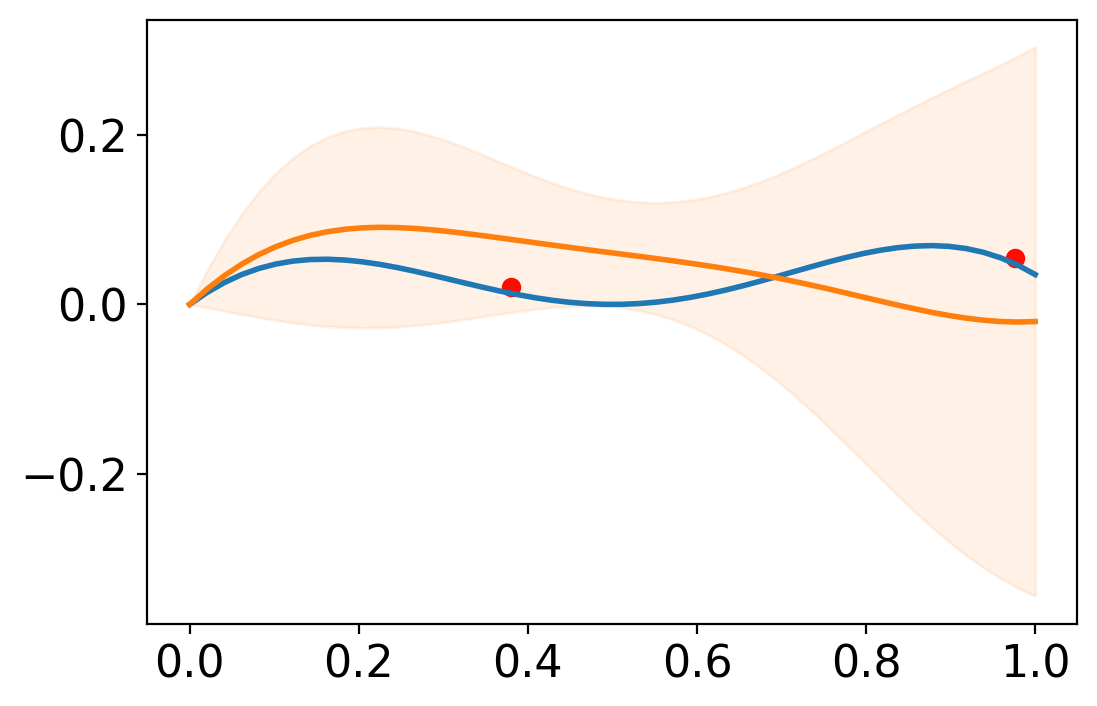

In [132]:
# Posterior predictive distribution

posterior_y_pred = np.array([[f(x, k) for x in x_plot] for k in kappa_samples])
print(posterior_y_pred.shape)

y_sample = np.mean(posterior_y_pred, axis = 0)
sig_sample = np.std(posterior_y_pred, axis = 0)


plt.plot(x_plot, y_plot)
plt.scatter(x_data, y_data, color='r')

h = plt.plot(x_plot, y_sample)
plt.fill_between(x_plot, y_sample + sig_sample, y_sample - sig_sample,
                 color=h[0].get_color(), alpha = 0.1)


Thus the three belief models each allow us to:

* Maintain belief on some unknown quantity
    * GP: response function
    * Linear model: coefficients to linear model
    * Discrete samples: parameters to non-linear model

* Update these beliefs based on new information:A

```
# GP:
model.fit(x_data[:, np.newaxis], (y_data-MU_Y)/SIGMA_Y)

# Linear model:
posterior_mu_theta = mu_theta + Sigma_theta @ Phi.T @ np.linalg.solve(Gamma, (y_data - Phi @ mu_theta))
posterior_Sigma_theta = Sigma_theta - Sigma_theta @ Phi.T @ np.linalg.solve(Gamma, Phi @ Sigma_theta)

# Discrete samples:
log_likelihood = -0.5*np.sum((prior_y_pred-y_data)**2 / SIGMA_W**2, axis=1)
posterior_weights = np.multiply(np.exp(log_likelihood), weights)
posterior_weights = posterior_weights / np.sum(posterior_weights)

```

* Make predictive distribution on response functions from posterior beliefs:

```
# GP:
y_gp, sig_gp = model.predict(x_plot[:, np.newaxis], return_std=True)

# Linear Model:
y_linear = Phi @ posterior_mu_theta
sig_linear = np.sqrt(np.diag(Phi @ posterior_Sigma_theta @ Phi.T))

# Discrete Samples:
posterior_y_pred = np.array([[f(x, k) for x in x_plot] for k in kappa_samples])
y_sample = np.mean(posterior_y_pred, axis = 0)
sig_sample = np.std(posterior_y_pred, axis = 0)
```

# Decision Making Policies


Text(0, 0.5, 'EI Value')

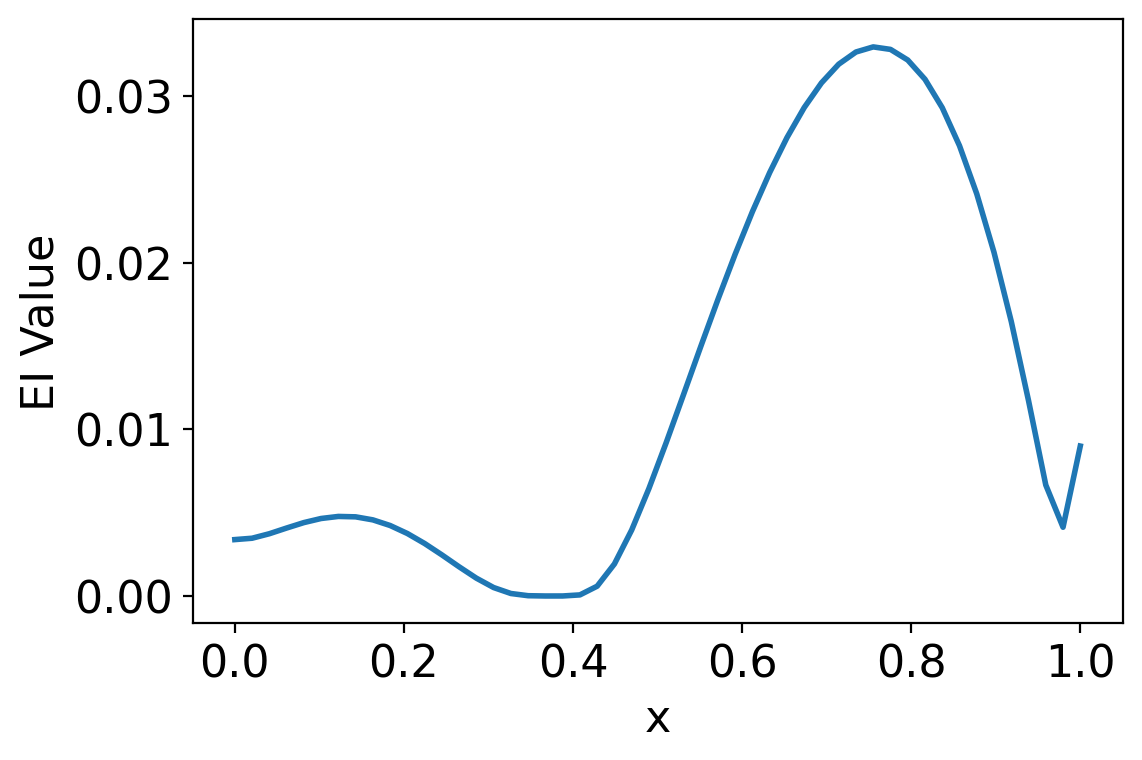

In [133]:
from scipy.stats import norm

# EI value using closed form solution (Gaussian assumption), and linear model
def EI(x_query, mu_theta, Sigma_theta, y_max):

    # predictive distribution
    Phi = np.array([[x**i for i in range(DEGREE+1)] for x in x_query])
    y_linear = Phi @ mu_theta
    sig_linear = np.sqrt(np.diag(Phi @ Sigma_theta @ Phi.T))

    # EI formula
    delta_x = y_linear - y_max
    z_x = delta_x / sig_linear
    return sig_linear * norm.pdf(z_x) + delta_x * norm.cdf(z_x)


ei_vals = EI(x_plot, posterior_mu_theta, posterior_Sigma_theta, np.max(y_data))
plt.plot(x_plot, ei_vals)
plt.xlabel('x')
plt.ylabel('EI Value')



(256, 50)
(256, 50)


Text(0, 0.5, 'EI Value')

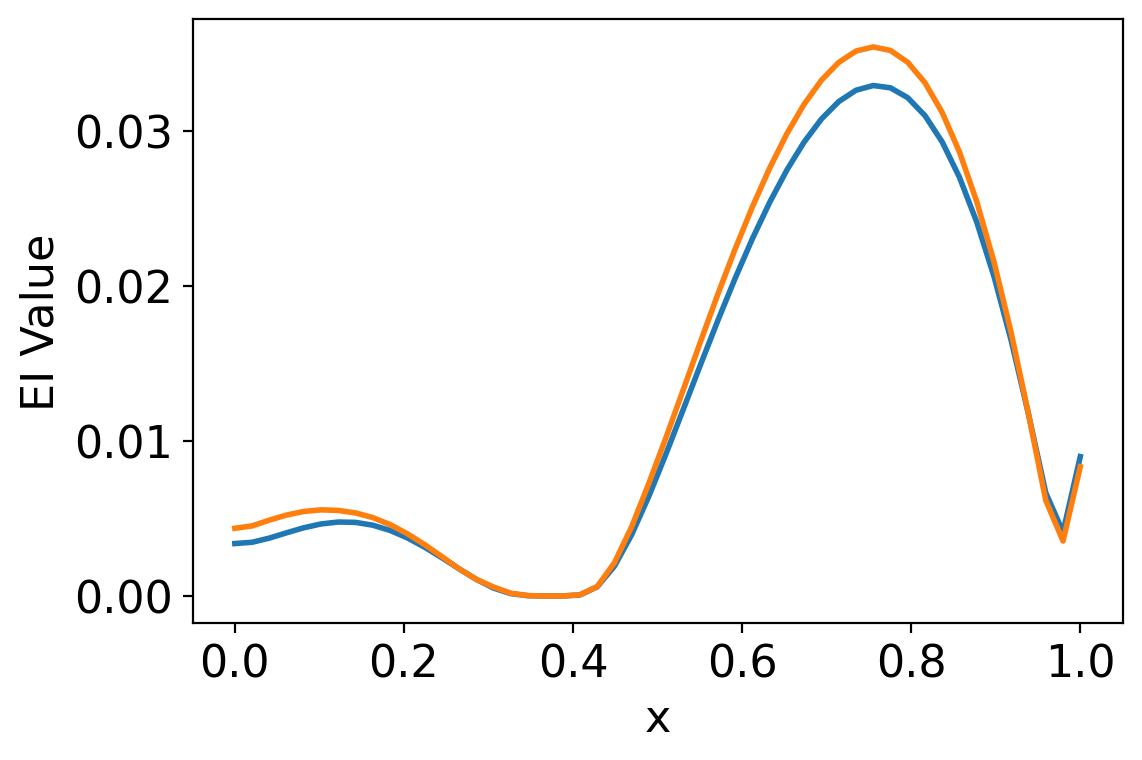

In [134]:
# Monte Carlo
def EI_MC(x_query, mu_theta, Sigma_theta, y_max, num_samples = 256):
    Phi = np.array([[x**i for i in range(DEGREE+1)] for x in x_query])

    # sample responses from posterior predictive distribution
    mu_y = Phi @ mu_theta
    Sigma_y = Phi @ Sigma_theta @ Phi.T
    y_samples = rng.multivariate_normal(mu_y, Sigma_y, size=num_samples)
    print(y_samples.shape)

    # Improvement
    improvement = np.maximum(y_samples - y_max, 0)
    print(improvement.shape)

    # Expected improvement
    return np.mean(improvement, axis=0)

ei_mc_vals = EI_MC(x_plot, posterior_mu_theta, posterior_Sigma_theta,
                   np.max(y_data))

plt.plot(x_plot, ei_vals)
plt.plot(x_plot, ei_mc_vals)
plt.xlabel('x')
plt.ylabel('EI Value')

In [135]:
# Expected change in mean parameter values

def E_dtheta(x_query, mu_theta, Sigma_theta, num_samples = 256):

    # sample responses from posterior predictive distribution
    Phi = np.array([[x**i for i in range(DEGREE+1)] for x in x_query])
    mu_y = Phi @ mu_theta
    Sigma_y = Phi @ Sigma_theta @ Phi.T
    y_samples = rng.multivariate_normal(mu_y, Sigma_y, size=num_samples)

    # CALCULATE UTILITY -- this block of code is analgous to the single line
    # calculating the improvement above in the EI_MC function.
    dtheta_samples = np.zeros(y_samples.shape)

    # For each x to score, calculate the expected change in posterior mean
    for j, x in enumerate(x_query):
        Phi_next = np.array([[x**k for k in range(DEGREE+1)]])

        # calculate sample change in theta, assuming sampled response
        for i, y in enumerate(y_samples[:, j]):
            # Posterior beliefs on theta
            Gamma = SIGMA_W**2 + Phi_next @ Sigma_theta @ Phi_next.T
            # Here Gamma is just a numnber, so we pull it out and divide at end
            mu = mu_theta + \
                 Sigma_theta @ Phi_next.T @ (y - Phi_next @ mu_theta)/Gamma

            # utility: the distance between prior and posterior estimates
            dtheta_samples[i,j] = np.linalg.norm(mu - mu_theta)
    # ---------------------- END CALCULATE UTILITY ---------------------------

    # Expected utility
    return np.mean(dtheta_samples, axis=0)

e_dtheta_vals = E_dtheta(x_plot, posterior_mu_theta, posterior_Sigma_theta)

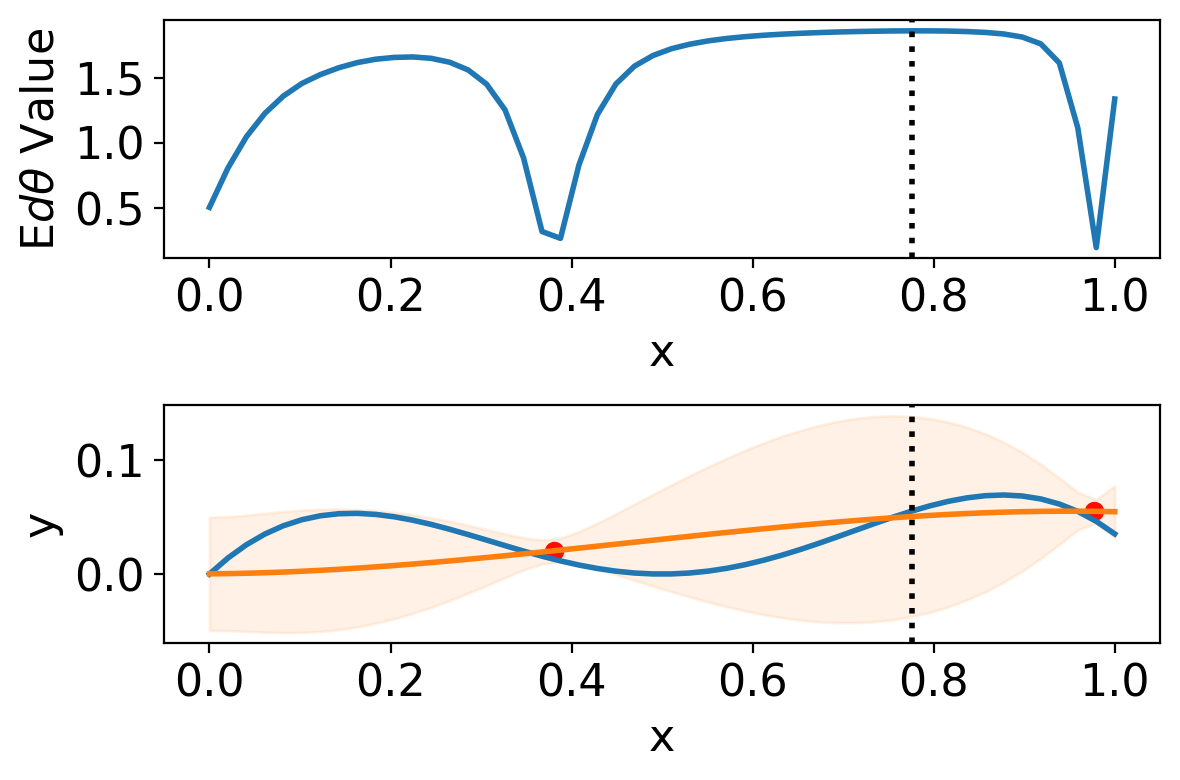

In [141]:
x_next = x_plot[np.argmax(e_dtheta_vals)]

# Plot values along with beliefs to compare
plt.subplot(2,1,1)
plt.plot(x_plot, e_dtheta_vals)

# Also plot location of maximum value
plt.axvline(x_next, color='k', linestyle=':')
plt.xlabel('x')
plt.ylabel(r'E$d\theta$ Value')

# compare with plot on beliefs
plt.subplot(2,1,2)
plt.plot(x_plot, y_plot)
plt.scatter(x_data, y_data, color='r')

h = plt.plot(x_plot, y_linear)
plt.fill_between(x_plot, y_linear + sig_linear, y_linear - sig_linear,
                 color=h[0].get_color(), alpha = 0.1)

# Also plot location of maximum value
plt.axvline(x_next, color='k', linestyle=':')

plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()